## 1. ndarray

In [1]:
from mxnet import nd

In [2]:
# row vector
x = nd.arange(12)
x


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
<NDArray 12 @cpu(0)>

In [3]:
# boardcasting
a = nd.arange(3).reshape((3, 1))
b = nd.arange(2).reshape((1, 2))
a, b

(
 [[0.]
  [1.]
  [2.]]
 <NDArray 3x1 @cpu(0)>, 
 [[0. 1.]]
 <NDArray 1x2 @cpu(0)>)

In [4]:
a + b


[[0. 1.]
 [1. 2.]
 [2. 3.]]
<NDArray 3x2 @cpu(0)>

## 2. autogradient

In [5]:
from mxnet import autograd

In [6]:
x = nd.arange(4).reshape((4, 1))
# using attach_grade to allocate memory for gradient
x.attach_grad()

with autograd.record():
    y = 2 * nd.dot(x.T, x)

y.backward()

In [7]:
x.grad, x.grad == 4 * x

(
 [[ 0.]
  [ 4.]
  [ 8.]
  [12.]]
 <NDArray 4x1 @cpu(0)>, 
 [[1.]
  [1.]
  [1.]
  [1.]]
 <NDArray 4x1 @cpu(0)>)

In [8]:
def f(a):
    """
    if with python conditional and loop control, we can also calculate gradient
    """
    b = a * 2
    while b.norm().asscalar() < 1000:
        b = b * 2
    if b.sum().asscalar() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [9]:
a = nd.random.normal(shape=1)
a.attach_grad()
with autograd.record():
    c = f(a)
c.backward()

In [10]:
a.grad == c / a


[1.]
<NDArray 1 @cpu(0)>

In [11]:
a = nd.random.normal(shape=(2, 2))
a.attach_grad()
with autograd.record():
    c = f(a)
c.backward()

In [12]:
a.grad == c / a


[[1. 1.]
 [1. 1.]]
<NDArray 2x2 @cpu(0)>

In [13]:
# print autograd
print(dir(autograd))

['CFUNCTYPE', 'Function', 'Lock', 'MXCallbackList', 'NDArray', 'NDArrayHandle', 'POINTER', 'Symbol', 'SymbolHandle', '_GRAD_REQ_MAP', '_LIB', '_RecordingStateScope', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_ndarray_cls', '_parse_head', 'absolute_import', 'array', 'backward', 'c_array', 'c_array_buf', 'c_handle_array', 'c_int', 'c_void_p', 'cast', 'check_call', 'ctypes', 'division', 'get_symbol', 'grad', 'is_recording', 'is_training', 'mark_variables', 'mx_uint', 'pause', 'predict_mode', 'record', 'set_recording', 'set_training', 'string_types', 'traceback', 'train_mode']


## 3. Linear Regression by Manual GD

page 37-42

In [14]:
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

%matplotlib inline

In [15]:
# generate dataset
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# bug: labels += gaussion noise with scale = 0.01, as 0.001 is too small, almost cost will be zero => 0.01 will better
labels += nd.random.normal(scale=0.01, shape=labels.shape)

In [16]:
features[0], labels[0]

(
 [ 1.5580711 -0.5459446]
 <NDArray 2 @cpu(0)>, 
 [9.173812]
 <NDArray 1 @cpu(0)>)

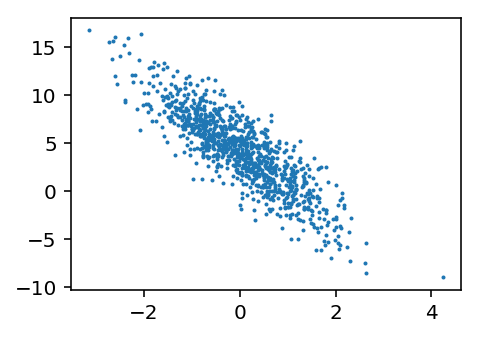

In [17]:
def set_figsize(figsize=(3.5, 2.5)):
    """
    analysis the linear relationship for different dimension.
    """
    # set retina
    set_matplotlib_formats('retina')
    # set size of graphic
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
# third parameter is c : color, sequence, or sequence of color, optional, default: ‘b’
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1)

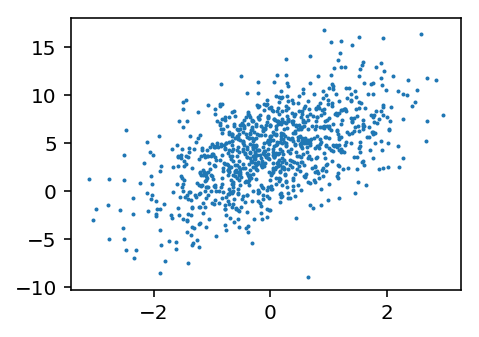

In [18]:
plt.scatter(features[:, 0].asnumpy(), labels.asnumpy(), 1)

In [19]:
batch_size = 10
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # read sample randomly
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        # take function to return elements
        yield features.take(j), labels.take(j)

In [20]:
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[ 0.9992367  -0.8613317 ]
 [-0.23331244 -0.90960723]
 [-0.8299827  -0.36128798]
 [ 0.07954837  0.596303  ]
 [-1.4225974   1.3172281 ]
 [-0.16102889  0.33972102]
 [-1.3000388   1.5999995 ]
 [-0.5292814  -0.82134813]
 [ 1.1491979   0.5591223 ]
 [ 1.1838405   0.654279  ]]
<NDArray 10x2 @cpu(0)> 
[ 9.121296   6.81124    3.7625031  2.3299725 -3.1283927  2.7240398
 -3.8292062  5.943457   4.6017094  4.3237557]
<NDArray 10 @cpu(0)>


In [21]:
# initialize w, b
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1, ))
params = [w, b]
# for params must attach for gradient descent
for param in params:
    param.attach_grad()

In [22]:
def linreg(X, w, b):
    return nd.dot(X, w) + b

In [23]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [24]:
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

### issue: why loss doesn't change

In [25]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

# training for num_epoches
for epoch in range(1, num_epochs + 1):
    #  using all samples in a batch
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            #  l is loss of (X, y) for a batch
            l = loss(net(X, w, b), y)
        # parameter gradient desent for batch
        l.backward()
        # using sgd for update parameters
        sgd([w, b], lr, batch_size)
    print('epoch %d, loss: %f' % (epoch, loss(net(features, w, b), labels).mean().asnumpy()))

epoch 1, loss: 0.034971
epoch 2, loss: 0.000126
epoch 3, loss: 0.000048
epoch 4, loss: 0.000048
epoch 5, loss: 0.000048
epoch 6, loss: 0.000048
epoch 7, loss: 0.000048
epoch 8, loss: 0.000048
epoch 9, loss: 0.000048
epoch 10, loss: 0.000048


In [26]:
true_w, w

([2, -3.4], 
 [[ 1.9995198]
  [-3.4001403]]
 <NDArray 2x1 @cpu(0)>)

In [27]:
true_b, b

(4.2, 
 [4.200344]
 <NDArray 1 @cpu(0)>)

## 4. Linear Regression by Gluon

page 42-46

In [28]:
# generate dataset
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# bug: labels += gaussion noise with scale = 0.01, as 0.001 is too small, almost cost will be zero => 0.01 will better
labels += nd.random.normal(scale=0.01, shape=labels.shape)

In [29]:
from mxnet.gluon import data as gdata

In [30]:
batch_size = 10
dataset = gdata.ArrayDataset(features, labels)
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

In [31]:
for X, y in data_iter:
    print(X, y)
    break


[[ 0.4630977   0.31019777]
 [-1.0228236  -0.31423238]
 [-1.5165006   0.3566635 ]
 [-0.2591015   2.1053827 ]
 [-0.15909493 -0.0301446 ]
 [-1.4742857   0.8200835 ]
 [-0.06222634  0.98236257]
 [-1.4445139   0.8161459 ]
 [-0.28918126 -0.56406903]
 [ 1.5935713   0.47377384]]
<NDArray 10x2 @cpu(0)> 
[ 4.0730577   3.206734   -0.03039612 -3.474611    3.9720814  -1.5609252
  0.7356147  -1.4438592   5.555827    5.775837  ]
<NDArray 10 @cpu(0)>


In [32]:
from mxnet.gluon import nn
from mxnet import init
from mxnet import gluon
from mxnet.gluon import loss as gloss

In [33]:
net = nn.Sequential()
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))
loss = gloss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

In [34]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    print("epoch %d, loss = %f" % (epoch, loss(net(features), labels).mean().asnumpy()))

epoch 1, loss = 0.058632
epoch 2, loss = 0.000277
epoch 3, loss = 0.000051
epoch 4, loss = 0.000049
epoch 5, loss = 0.000049
epoch 6, loss = 0.000049
epoch 7, loss = 0.000049
epoch 8, loss = 0.000049
epoch 9, loss = 0.000049
epoch 10, loss = 0.000049


In [35]:
dense = net[0]
true_w, dense.weight.data()

([2, -3.4], 
 [[ 1.9998894 -3.3999848]]
 <NDArray 1x2 @cpu(0)>)

In [36]:
true_b, dense.bias.data()

(4.2, 
 [4.1999855]
 <NDArray 1 @cpu(0)>)